## Workload Forecasting EDA

___
### Generic Imports

In [1]:
import pandas as pd
import glob, os
pd.set_option("display.max_columns", 50)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(250, 8)})

import numpy as np
np.random.seed(sum(map(ord, 'calmap')))
import calmap

import itertools
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

from pylab import rcParams
rcParams['figure.figsize'] = 200, 8

from statsmodels.tsa.stattools import adfuller

### Loading the dataset

In [2]:
issues_df = pd.read_csv('Apache_all_issues.csv', index_col = 0)

### Visualizing the dataset

In [3]:
issues_df.head()

,Issue_Type,Issue_key,Issue_id,Parent_id,Assignee,Priority,Status,Resolution,Created,Updated,Time_Spent,Cuml_Time_Spent,Bug_Category,Issue_queue,Issue_queue_key
0,Improvement,OAK-3861,12929198,NaN,stillalex,Trivial,Closed,Fixed,11/Jan/16 15:03,02/Mar/16 15:17,NaN,NaN,NaN,OAK,3861
1,Bug,CB-10318,12929199,NaN,alsorokin,Major,Closed,Fixed,11/Jan/16 15:08,11/Jan/16 15:24,NaN,NaN,NaN,CB,10318
2,Bug,CALCITE-1051,12929200,NaN,julianhyde,Minor,Closed,Fixed,11/Jan/16 15:09,21/Jan/16 22:20,NaN,NaN,NaN,CALCITE,1051
3,Bug,SPARK-12754,12929201,NaN,NaN,Major,Resolved,Cannot Reproduce,11/Jan/16 15:13,10/Jan/17 07:21,NaN,NaN,NaN,SPARK,12754
4,Bug,AMQ-6122,12929202,NaN,tabish,Critical,Resolved,Fixed,11/Jan/16 15:22,12/Jan/16 17:02,NaN,NaN,NaN,AMQ,6122


### Dataset Information

In [4]:
issues_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363240 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Issue_Type       363240 non-null  object 
 1   Issue_key        363240 non-null  object 
 2   Issue_id         363240 non-null  int64  
 3   Parent_id        39732 non-null   float64
 4   Assignee         249712 non-null  object 
 5   Priority         363056 non-null  object 
 6   Status           363240 non-null  object 
 7   Resolution       278939 non-null  object 
 8   Created          363240 non-null  object 
 9   Updated          363240 non-null  object 
 10  Time_Spent       42171 non-null   float64
 11  Cuml_Time_Spent  42888 non-null   float64
 12  Bug_Category     431 non-null     object 
 13  Issue_queue      363240 non-null  object 
 14  Issue_queue_key  363240 non-null  int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 44.3+ MB


### Data Pre-Processing
___
#### Data Cleansing

In [5]:
# The datatype of Created and Updated column are Object where as they are represntative datetime
# converting Created and Updated columns to date time type

issues_df_dc1 = issues_df
issues_df_dc1.Created = pd.to_datetime(issues_df.Created, format='%d/%b/%y %H:%M')
issues_df_dc1.Updated = pd.to_datetime(issues_df.Updated, format='%d/%b/%y %H:%M')

issues_df_dc1[['Created', 'Updated']].describe()

,Created,Updated
count,363240,363240
unique,325749,233386
top,2017-07-19 07:39:00,2019-04-16 09:30:00
freq,82,2244
first,2016-01-01 00:13:00,2016-01-01 00:20:00
last,2020-08-14 23:59:00,2020-08-15 22:16:00


In [6]:
# even though Issue_id, Parent_id and Issue_queue_key are numerical they are categorical in nature so lets update its data type
issues_df_dc1['Issue_id'] = issues_df_dc1.Issue_id.astype('category')
issues_df_dc1['Parent_id'] = issues_df_dc1.Parent_id.astype('category')
issues_df_dc1['Issue_queue_key'] = issues_df_dc1.Issue_queue_key.astype('category')

issues_df_dc1[['Issue_id', 'Parent_id', 'Issue_queue_key']].describe()

,Issue_id,Parent_id,Issue_queue_key
count,363240,39732.0,363240
unique,363240,5913.0,32961
top,13322832,12747878.0,1
freq,1,561.0,92


#### Missing Values Treatment (MVT) 

1. High missing values in column (to be dropped from data set)

In [7]:
missing_percentage = round(issues_df_dc1.isnull().sum(axis = 0)/issues_df_dc1.shape[0]*100,2)
missing_percentage

Issue_Type          0.00
Issue_key           0.00
Issue_id            0.00
Parent_id          89.06
Assignee           31.25
Priority            0.05
Status              0.00
Resolution         23.21
Created             0.00
Updated             0.00
Time_Spent         88.39
Cuml_Time_Spent    88.19
Bug_Category       99.88
Issue_queue         0.00
Issue_queue_key     0.00
dtype: float64

In [8]:
# after dropping columns with more than 20% missing values
issues_df_mvt1 = issues_df[[col for col, val in missing_percentage.iteritems() if val < 20]]

2. There is only one coulmn "Priority" which has missing values

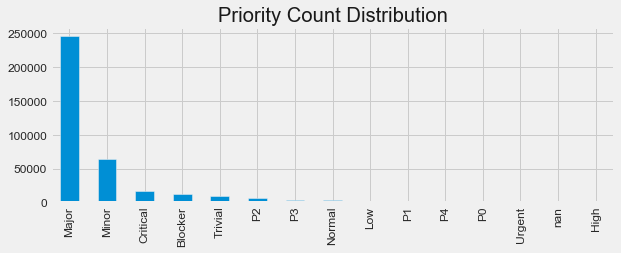

,Major,Minor,Critical,Blocker,Trivial,P2,P3,Normal,Low,P1,P4,P0,Urgent,NaN,High
Priority,246578,63847,16038,11554,9997,5771,3713,3259,1234,351,244,234,216,184,20


In [9]:
# understanding distribution of Priority column
plt.figure(figsize=(9, 3))
plt.title("Priority Count Distribution")
issues_df_mvt1['Priority'].value_counts(dropna=False).plot(kind='bar')
plt.show()
pd.DataFrame(issues_df_mvt1['Priority'].value_counts(dropna=False)).T

3. Imputing missing data for Priority column (Imputing most frequent category "Major")

In [10]:
# majority of issues fall under Major priority so imputing the 184 missing issues to Major will not have much impact on our analysis
issues_df_mvt2 = issues_df_mvt1.replace(np.nan, 'Major', regex=True)
pd.DataFrame(issues_df_mvt2['Priority'].value_counts(dropna=False)).T

,Major,Minor,Critical,Blocker,Trivial,P2,P3,Normal,Low,P1,P4,P0,Urgent,High
Priority,246762,63847,16038,11554,9997,5771,3713,3259,1234,351,244,234,216,20


4. With the above steps all missing values have been taken care so missing values analysis for row is not necessary for this dataset

#### Duplicate Entries Check

In [11]:
print("Count of duplicate records in the dataset: ", issues_df_mvt2.duplicated().sum())

Count of duplicate records in the dataset:  0


#### Understanding Data Distribution

In [12]:
issues_df_mvt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363240 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Issue_Type       363240 non-null  object        
 1   Issue_key        363240 non-null  object        
 2   Issue_id         363240 non-null  category      
 3   Priority         363240 non-null  object        
 4   Status           363240 non-null  object        
 5   Created          363240 non-null  datetime64[ns]
 6   Updated          363240 non-null  datetime64[ns]
 7   Issue_queue      363240 non-null  object        
 8   Issue_queue_key  363240 non-null  category      
dtypes: category(2), datetime64[ns](2), object(5)
memory usage: 39.2+ MB


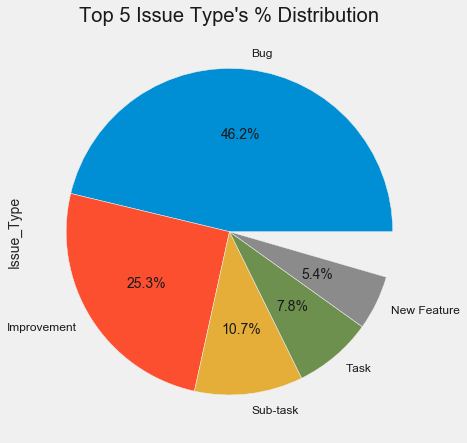

In [13]:
# understanding distribution of Issue_Type column
plt.figure(figsize=(7, 7))
plt.title("Top 5 Issue Type's % Distribution")
(issues_df_mvt2['Issue_Type'].value_counts()/issues_df_mvt2['Issue_Type'].count()).head(5).plot(kind='pie',autopct='%1.1f%%')
plt.show()

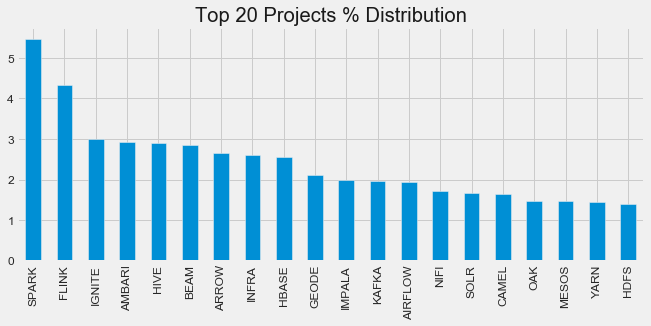

In [14]:
# understanding % distribution of Issue_queue column over top 40 Projects
plt.figure(figsize=(10, 4))
plt.title("Top 20 Projects % Distribution")
(issues_df_mvt2['Issue_queue'].value_counts()/issues_df_mvt2['Issue_queue'].count() * 100).head(20).plot(kind='bar')
plt.show()

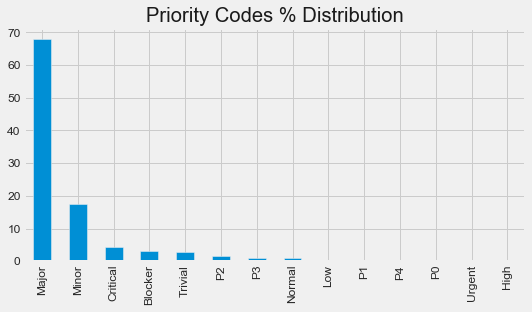

In [15]:
# understanding % distribution of Priority column
plt.figure(figsize=(8, 4))
plt.title("Priority Codes % Distribution")
(issues_df_mvt2['Priority'].value_counts()/issues_df_mvt2['Priority'].count() * 100).plot(kind='bar')
plt.show()

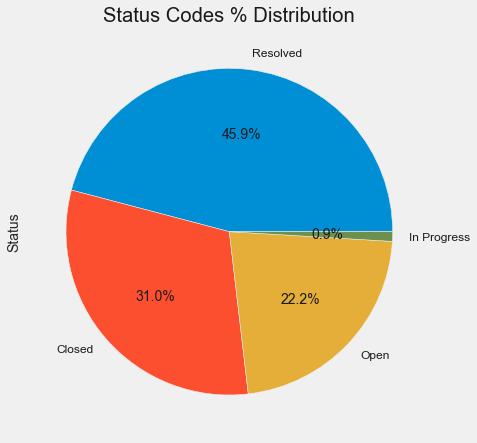

In [16]:
# understanding % distribution of Status column for top 5 status
plt.figure(figsize=(7, 7))
plt.title("Status Codes % Distribution")
issues_df_mvt2['Status'].value_counts().head(5).plot(kind='pie',autopct='%1.1f%%')
plt.show()

In [17]:
# Understanding distribution of tickets in a timeline view for 1st year with respect to created date of issues
# Understanding distribution of tickets in a calander view for all the data points with respect to created date of issues

issues_df_mvt2_cal = issues_df_mvt2
issues_df_mvt2_cal['Created_date'] = issues_df_mvt2['Created'].dt.date
issues_df_mvt2_cal['Updated_date'] = issues_df_mvt2['Updated'].dt.date
issues_df_mvt2_cal_created = pd.crosstab(issues_df_mvt2.Created_date, issues_df_mvt2.Status)
issues_df_mvt2_cal_updated = pd.crosstab(issues_df_mvt2.Updated_date, issues_df_mvt2.Status)

issues_df_mvt2_cal_created.index = pd.to_datetime(issues_df_mvt2_cal_created.index, format='%Y-%m-%d')
issues_df_mvt2_cal_updated.index = pd.to_datetime(issues_df_mvt2_cal_updated.index, format='%Y-%m-%d')

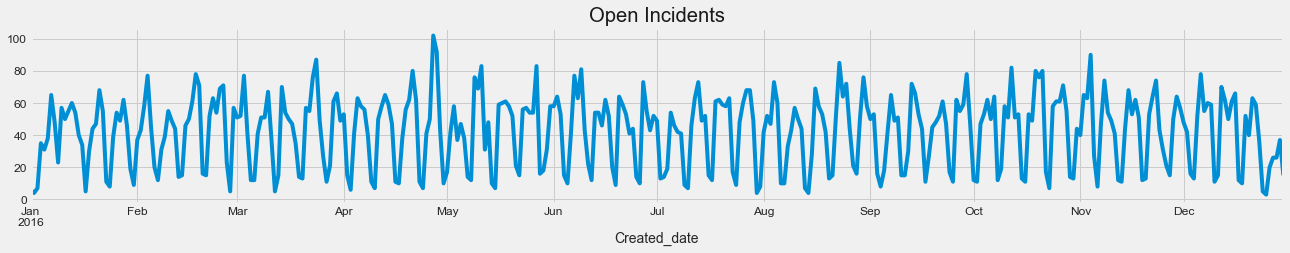

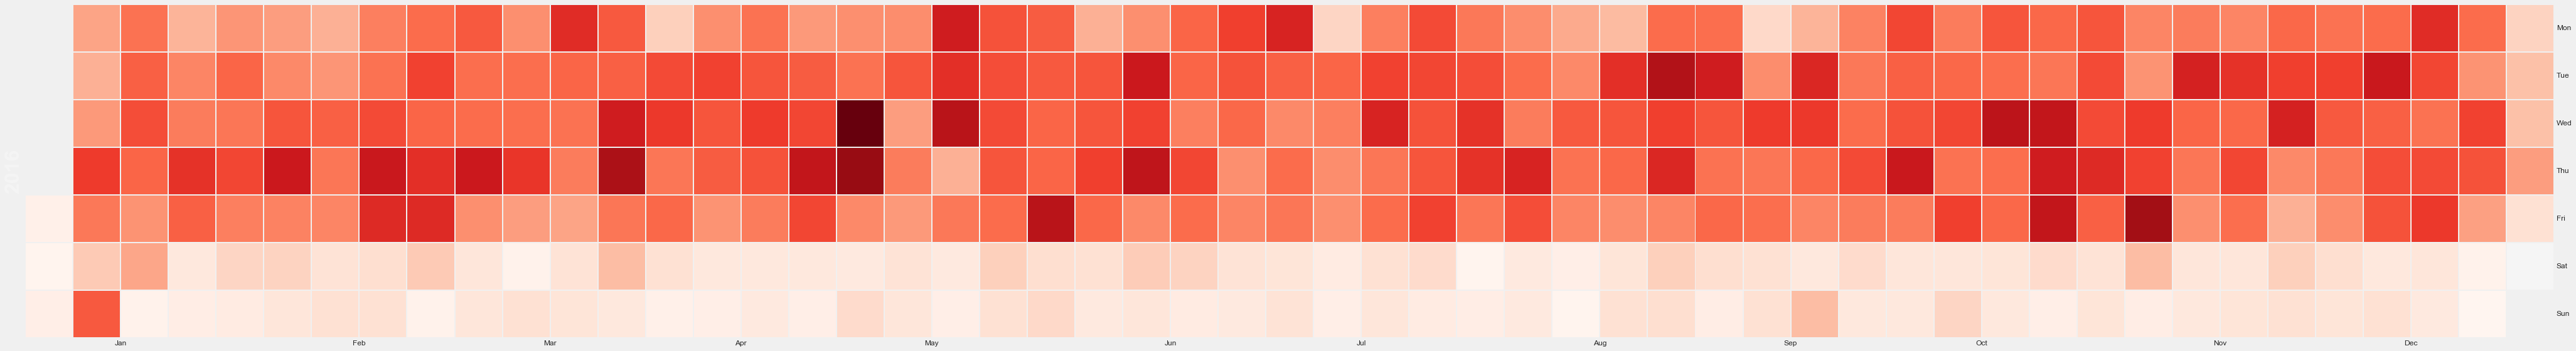

In [18]:
plt.figure(figsize=(20, 3))
plt.title("Open Incidents")
issues_df_mvt2_cal_created['Open'].head(365).plot()
calmap.calendarplot(issues_df_mvt2_cal_created['Open'].head(365))
plt.show()

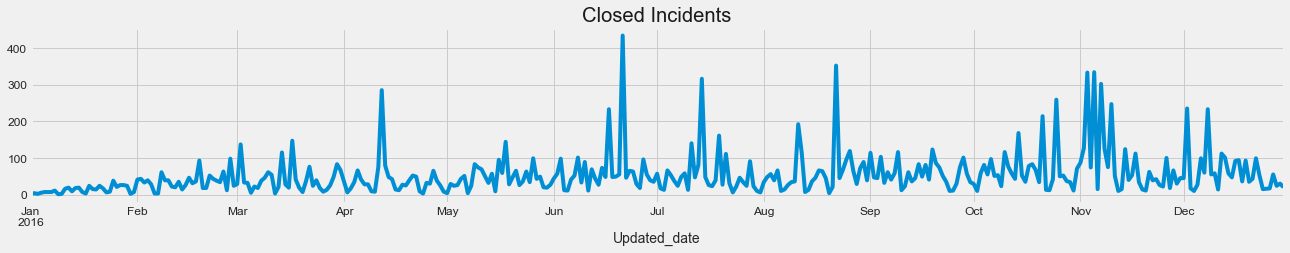

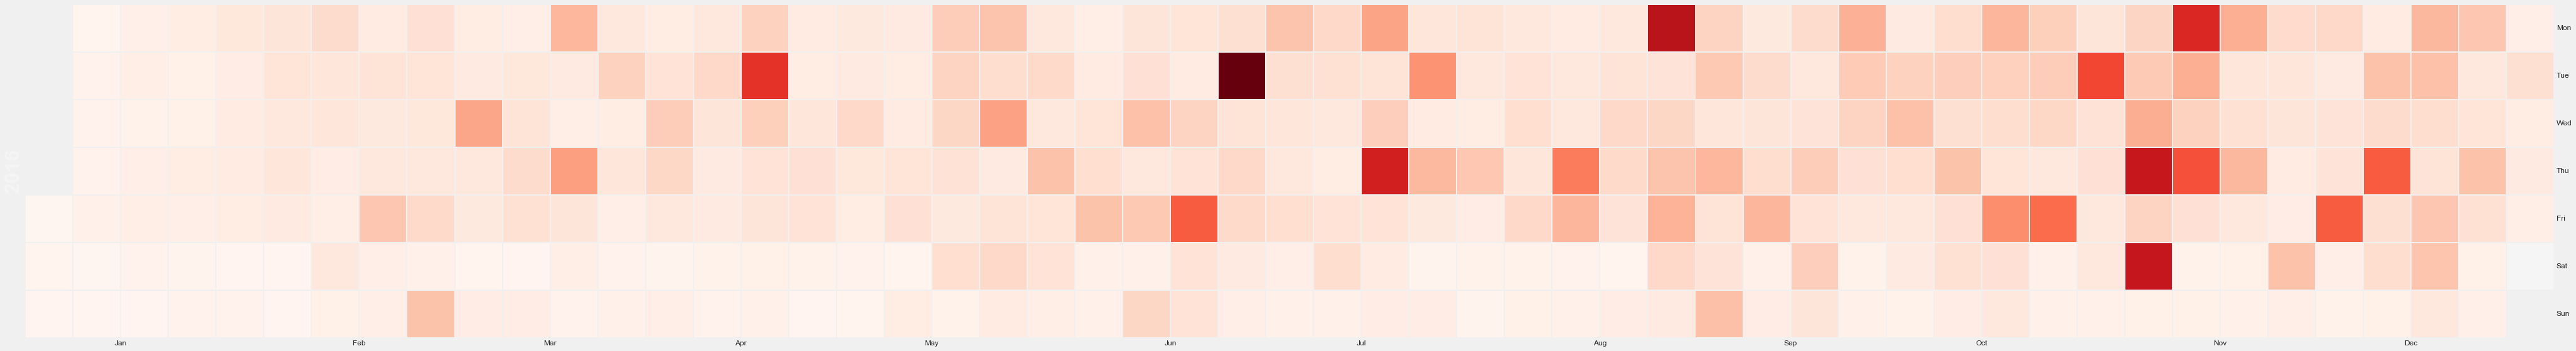

In [19]:
plt.figure(figsize=(20, 3))
plt.title("Closed Incidents")
issues_df_mvt2_cal_updated['Closed'].head(365).plot()
calmap.calendarplot(issues_df_mvt2_cal_updated['Closed'].head(365))
plt.show()

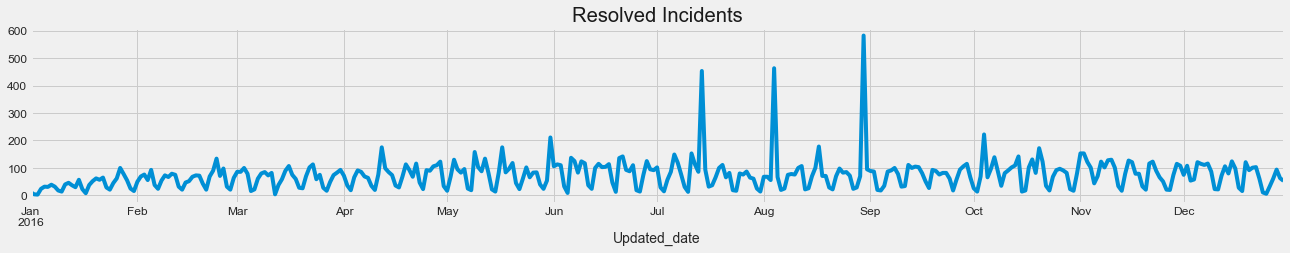

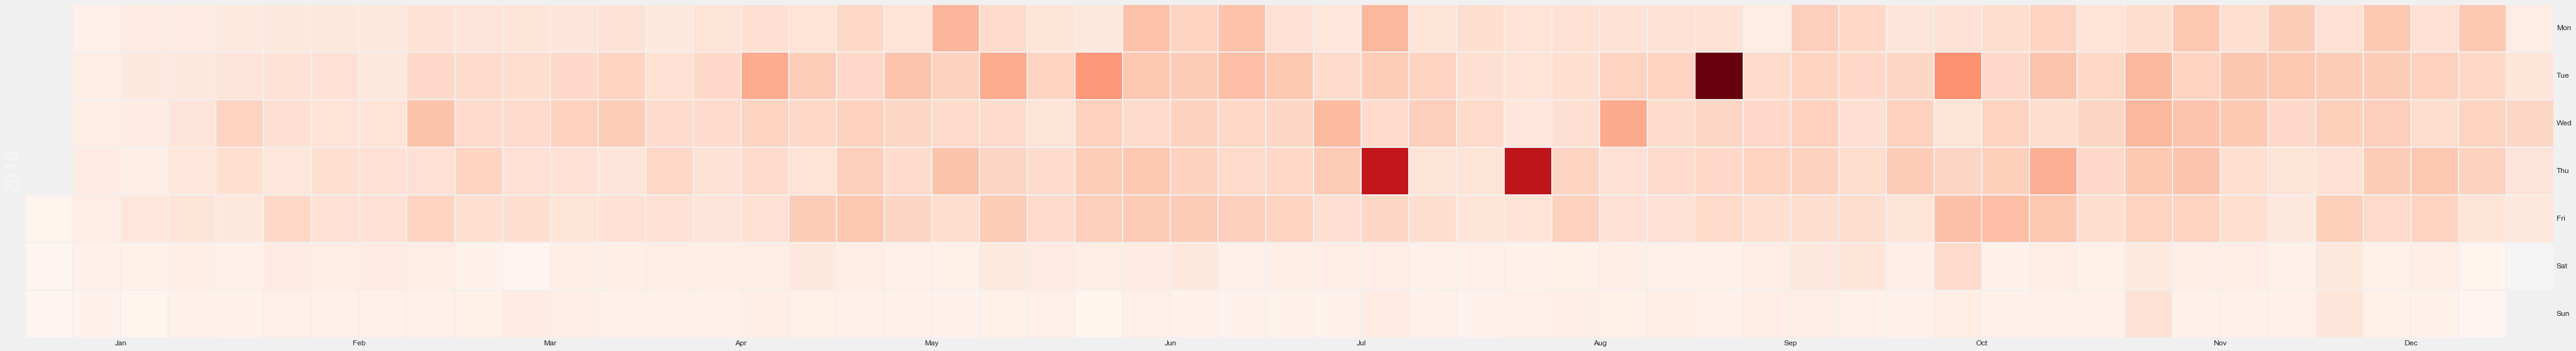

In [20]:
plt.figure(figsize=(20, 3))
plt.title("Resolved Incidents")
issues_df_mvt2_cal_updated['Resolved'].head(365).plot()
calmap.calendarplot(issues_df_mvt2_cal_updated['Resolved'].head(365))
plt.show()

### Feature Engineering for Forecasting

In [21]:
final_timeseries_df = pd.merge(pd.DataFrame(issues_df_mvt2_cal_created.Open), pd.DataFrame(issues_df_mvt2_cal_updated[['Closed','Resolved']]).head(-1), left_index=True, right_index=True)

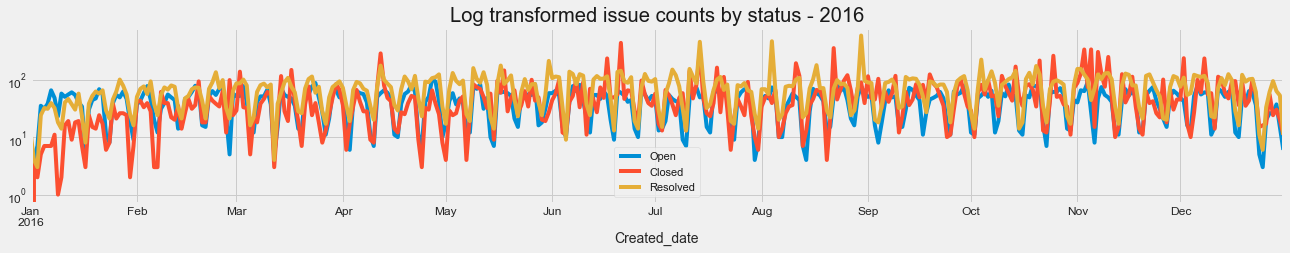

In [22]:
final_timeseries_df.head(366).plot(logy=True, title="Log transformed issue counts by status - 2016", figsize=(20,3))

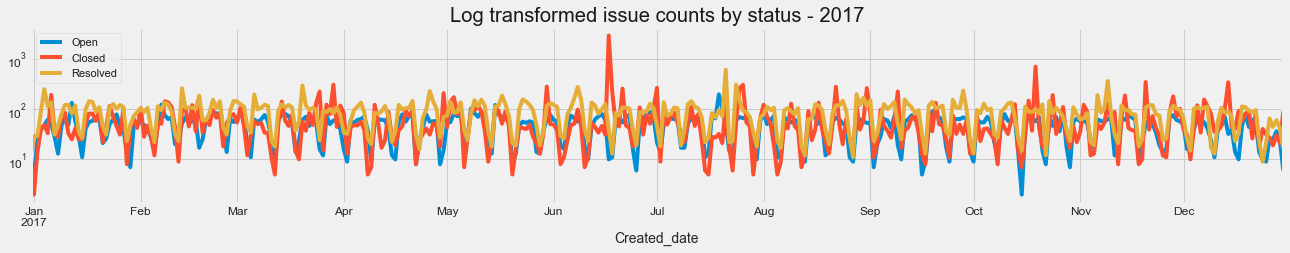

In [23]:
final_timeseries_df.head(365*2).tail(365).plot(logy=True, title="Log transformed issue counts by status - 2017", figsize=(20,3))

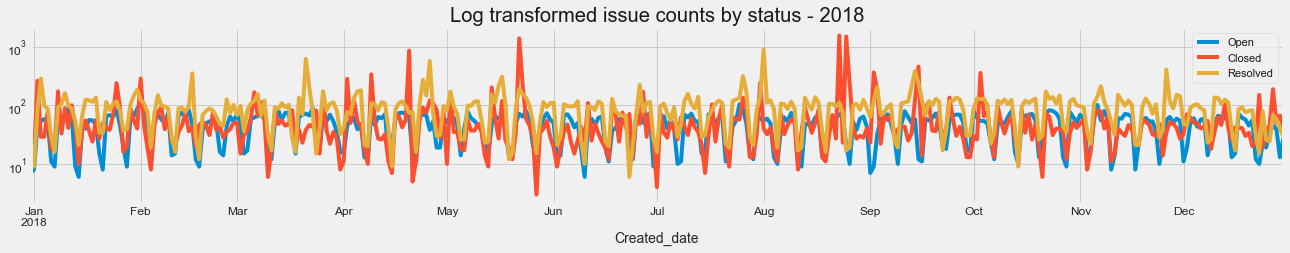

In [24]:
final_timeseries_df.head(365*3).tail(365).plot(logy=True, title="Log transformed issue counts by status - 2018", figsize=(20,3))

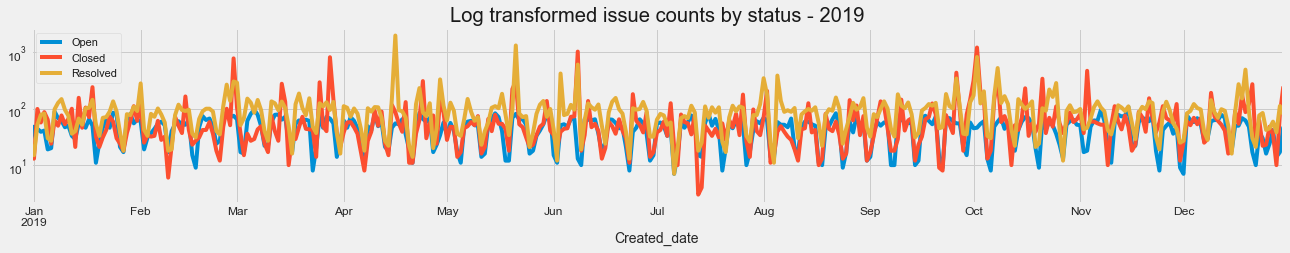

In [25]:
final_timeseries_df.head(365*4).tail(365).plot(logy=True, title="Log transformed issue counts by status - 2019", figsize=(20,3))

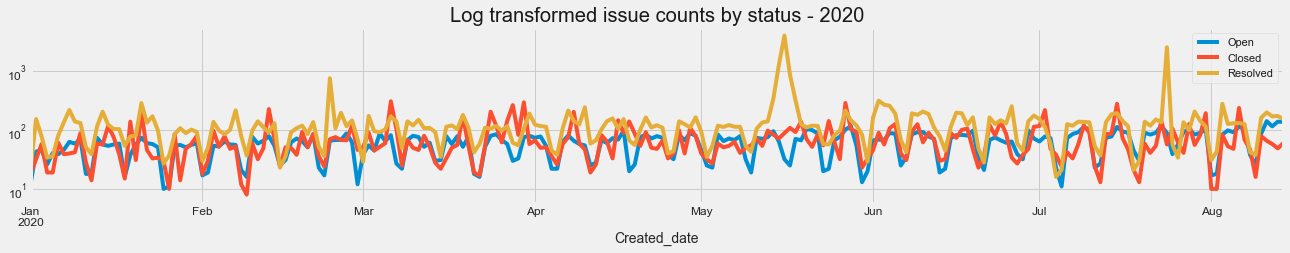

In [26]:
final_timeseries_df.head(365*5).tail(227).plot(logy=True, title="Log transformed issue counts by status - 2020", figsize=(20,3))

In [27]:
final_timeseries_df.to_csv("final_timeseries_df.csv")

### ACF and PACF With Seasonal Decomposition

Results of Dickey-Fuller Test:
p-value = 0.0005. The series is likely stationary.
Test Statistic                   -4.288982
p-value                           0.000464
#Lags Used                       15.000000
Number of Observations Used    1672.000000
Critical Value (1%)              -3.434267
Critical Value (5%)              -2.863270
Critical Value (10%)             -2.567691
dtype: float64


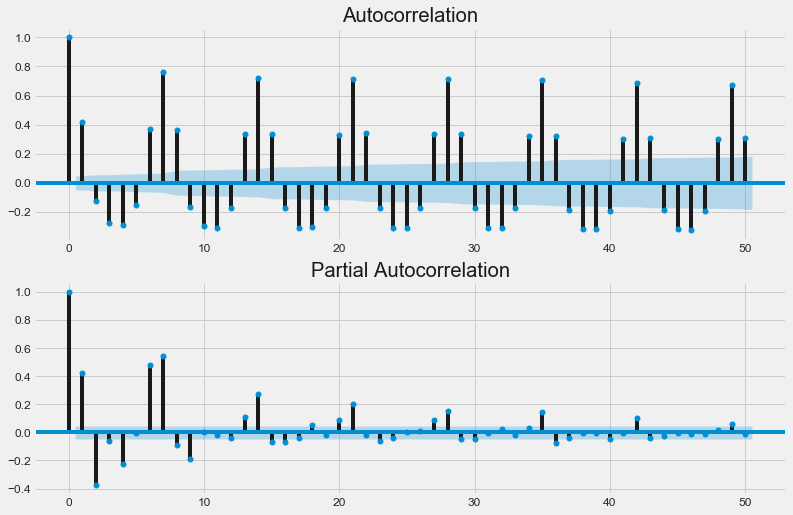

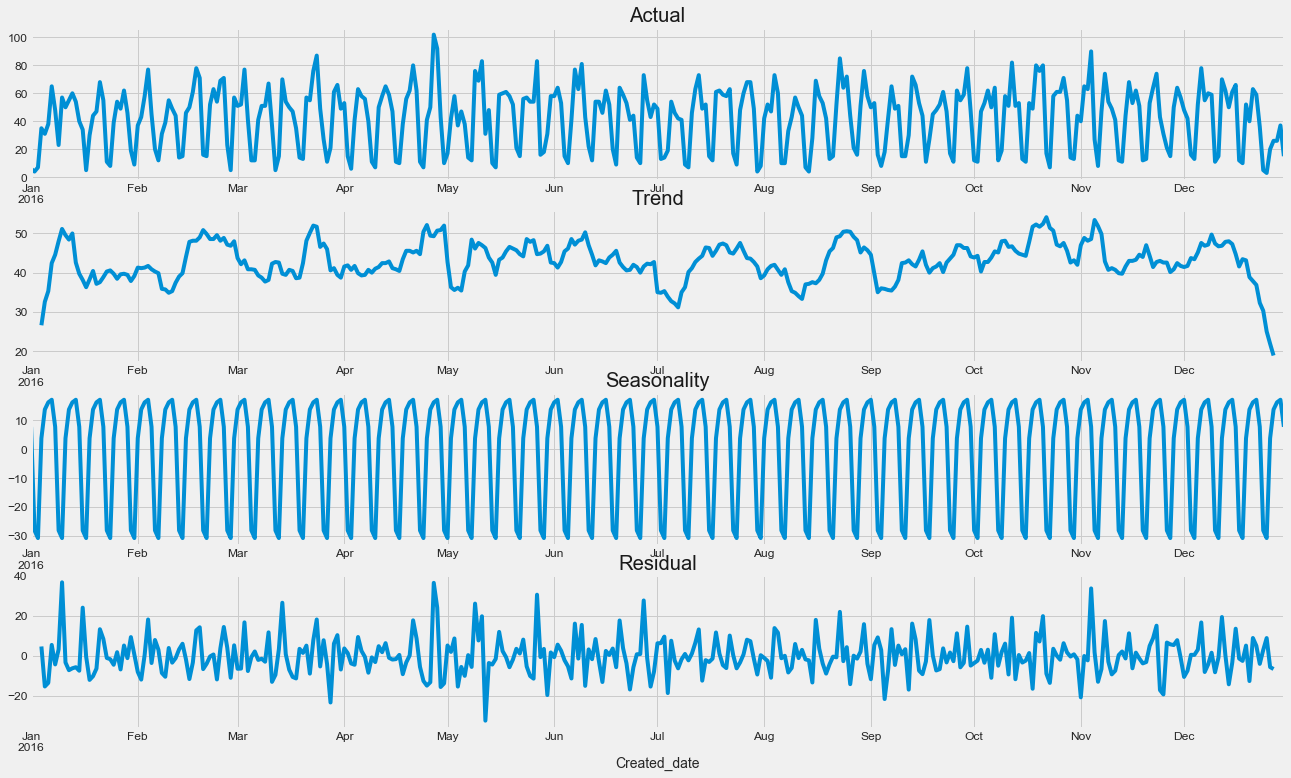

In [28]:
series=final_timeseries_df.Open
def test_stationarity(timeseries, window = 4, cutoff = 0.01):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 15 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, lags=50, ax=ax1) # 
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=50, ax=ax2)# , lags=40
    
test_stationarity(series)

res = seasonal_decompose(series.head(365), model='additive')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,12))
series.head(365).plot(ax=ax1, title="Actual")
res.trend.plot(ax=ax2, title="Trend")
res.seasonal.plot(ax=ax3, title="Seasonality")
res.resid.plot(ax=ax4, title="Residual")
plt.show()

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -25.813670
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1686.000000
Critical Value (1%)              -3.434235
Critical Value (5%)              -2.863256
Critical Value (10%)             -2.567683
dtype: float64


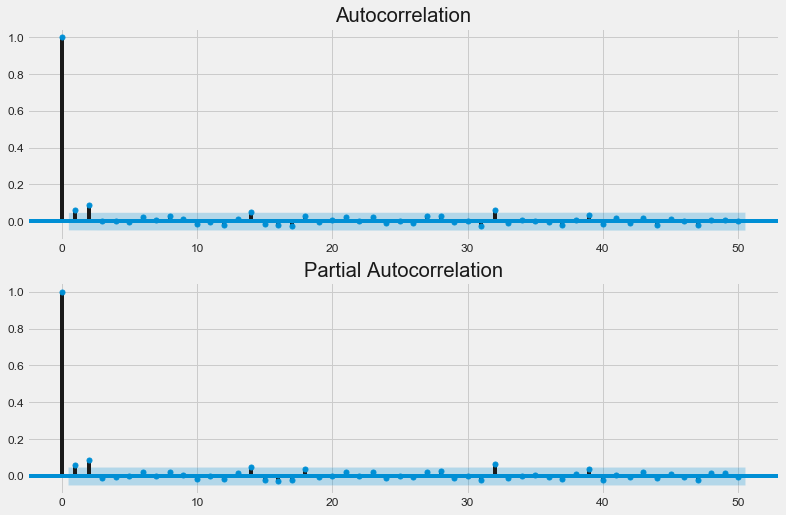

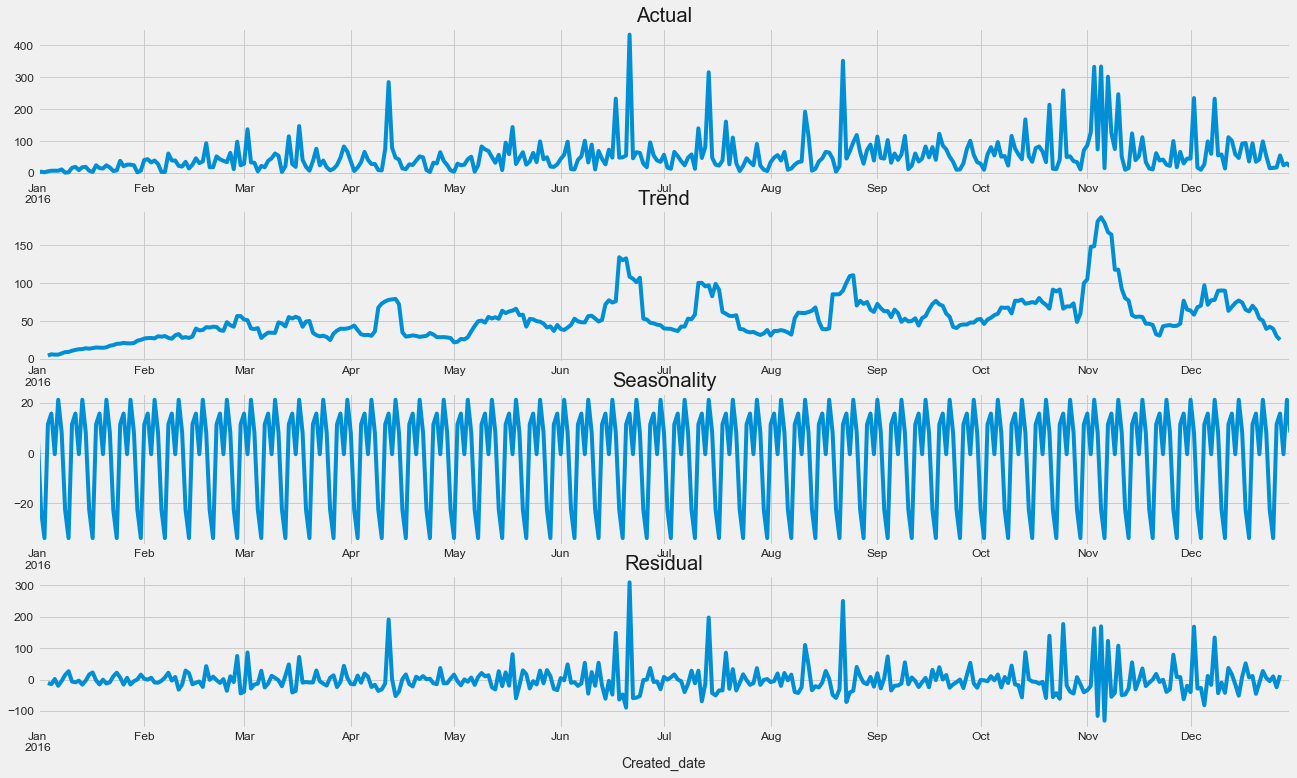

In [29]:
series=final_timeseries_df.Closed
def test_stationarity(timeseries, window = 4, cutoff = 0.01):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 15 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, lags=50, ax=ax1) # 
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=50, ax=ax2)# , lags=40
    
test_stationarity(series)

res = seasonal_decompose(series.head(365), model='additive')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,12))
series.head(365).plot(ax=ax1, title="Actual")
res.trend.plot(ax=ax2, title="Trend")
res.seasonal.plot(ax=ax3, title="Seasonality")
res.resid.plot(ax=ax4, title="Residual")
plt.show()

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -31.166509
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1687.000000
Critical Value (1%)              -3.434232
Critical Value (5%)              -2.863255
Critical Value (10%)             -2.567683
dtype: float64


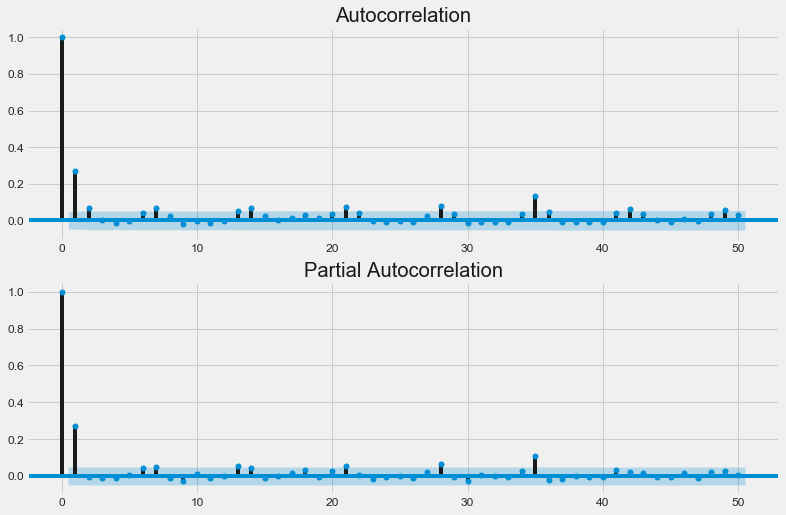

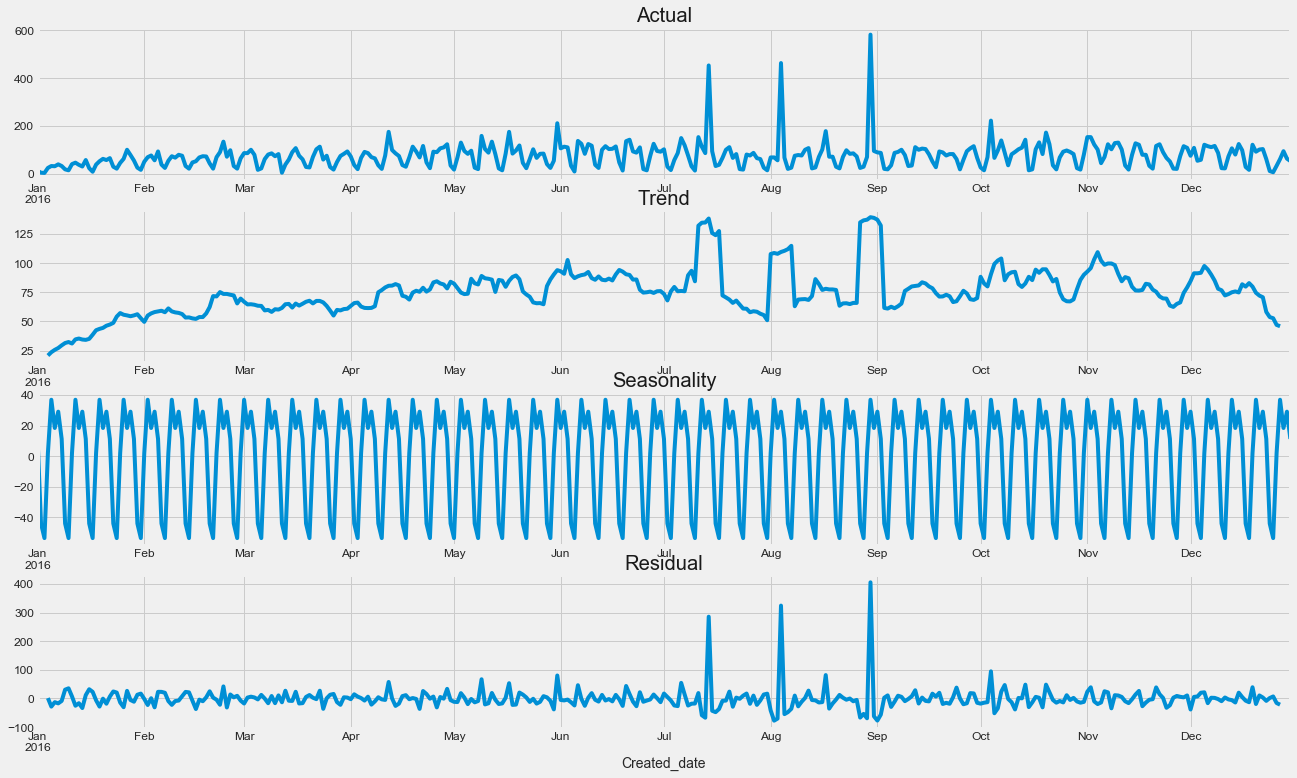

In [30]:
series=final_timeseries_df.Resolved
def test_stationarity(timeseries, window = 4, cutoff = 0.01):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 15 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, lags=50, ax=ax1) # 
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=50, ax=ax2)# , lags=40
    
test_stationarity(series)

res = seasonal_decompose(series.head(365), model='additive')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,12))
series.head(365).plot(ax=ax1, title="Actual")
res.trend.plot(ax=ax2, title="Trend")
res.seasonal.plot(ax=ax3, title="Seasonality")
res.resid.plot(ax=ax4, title="Residual")
plt.show()